In [1]:
# Open training, testing subsets from https://doi.org/10.1021/acs.energyfuels.0c01533
from csv import DictReader

with open('schweidtmann_train.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds_train = [r for r in reader]
csv_file.close()
with open('schweidtmann_test.csv', 'r') as csv_file:
    reader = DictReader(csv_file)
    compounds_test = [r for r in reader]
csv_file.close()

print(len(compounds_train), len(compounds_test))

# Filter out compounds with `n.a.` RON or MON data
compounds_train = [c for c in compounds_train if c['Meas MON'] != 'n.a.' and c['Meas RON'] != 'n.a.']
compounds_test = [c for c in compounds_test if c['Meas MON'] != 'n.a.' and c['Meas RON'] != 'n.a.']

print(len(compounds_train), len(compounds_test))

430 75
265 51


In [2]:
# Format data for training
from ecnet.datasets.structs import QSPRDataset

smiles_train = [c[' SMILES'] for c in compounds_train]
os_train = [[float(c['Meas RON']) - float(c['Meas MON'])] for c in compounds_train]
smiles_test = [c[' SMILES'] for c in compounds_test]
os_test = [[float(c['Meas RON']) - float(c['Meas MON'])] for c in compounds_test]

dataset_train = QSPRDataset(smiles_train, os_train, backend='alvadesc')
dataset_test = QSPRDataset(smiles_test, os_test, backend='alvadesc')

print(len(dataset_train), len(dataset_test))

265 51


In [3]:
# Select most-influential descriptors w.r.t. OS for NN input variables
from ecnet.tasks.feature_selection import select_rfr

print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
desc_idx, desc_imp = select_rfr(dataset_train, total_importance=0.99999, n_estimators=128, n_jobs=8)
dataset_train.set_desc_index(desc_idx)
dataset_test.set_desc_index(desc_idx)
print(dataset_train.desc_vals.shape, dataset_test.desc_vals.shape)
print(dataset_train.desc_names[:5], desc_imp[:5])

torch.Size([265, 5305]) torch.Size([51, 5305])
torch.Size([265, 1540]) torch.Size([51, 1540])
['SpMax1_Bh(s)', 'AVS_B(s)', 'SpMax_B(s)', 'Chi_Dz(p)', 'Chi_Dz(v)'] [0.12884247456932435, 0.090385738236594, 0.05504736129984135, 0.04507311886801459, 0.03286720732824119]


Epoch: 0 | Train loss: 138.39182890304411 | Valid loss: 9223372036854775807
Epoch: 10 | Train loss: 42.26695616076691 | Valid loss: 39.08465576171875
Epoch: 20 | Train loss: 26.33659980273006 | Valid loss: 17.67534637451172
Epoch: 30 | Train loss: 26.92900177926728 | Valid loss: 13.135091781616211
Epoch: 40 | Train loss: 24.46118840304288 | Valid loss: 21.84608268737793
Epoch: 50 | Train loss: 20.002332757217715 | Valid loss: 12.559040069580078
Epoch: 60 | Train loss: 17.26384602171002 | Valid loss: 15.41850757598877
Epoch: 70 | Train loss: 15.689023798162287 | Valid loss: 9.815067291259766
Epoch: 80 | Train loss: 15.726439740922716 | Valid loss: 10.650335311889648
Epoch: 90 | Train loss: 15.371660757546474 | Valid loss: 10.009864807128906
Epoch: 100 | Train loss: 15.331992293849137 | Valid loss: 11.820895195007324
Epoch: 110 | Train loss: 17.304635428419015 | Valid loss: 9.540414810180664
Epoch: 120 | Train loss: 12.394793192545572 | Valid loss: 8.891639709472656
Epoch: 130 | Train lo

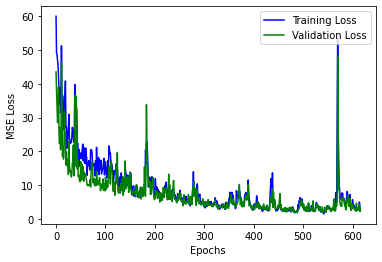

In [4]:
# Train model
from ecnet import ECNet
from matplotlib import pyplot as plt

model = ECNet(dataset_train.desc_vals.shape[1], dataset_train.target_vals.shape[1], 2048, 3, 0.0)
train_loss, valid_loss = model.fit(
    dataset=dataset_train, valid_size=0.25, shuffle=True, verbose=10,
    patience=128, epochs=2000, lr=0.0005, lr_decay=0.0
)

train_loss = train_loss[5:]
valid_loss = valid_loss[5:]

epoch = [i for i in range(len(train_loss))]
plt.clf()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.plot(epoch, train_loss, color='blue', label='Training Loss')
plt.plot(epoch, valid_loss, color='green', label='Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [5]:
from sklearn.metrics import mean_absolute_error, r2_score

y_hat_train = model(dataset_train.desc_vals).detach().numpy()
y_train = dataset_train.target_vals.numpy()
y_hat_test = model(dataset_test.desc_vals).detach().numpy()
y_test = dataset_test.target_vals.numpy()

mae_train = mean_absolute_error(y_train, y_hat_train)
mae_test = mean_absolute_error(y_test, y_hat_test)
r2_train = r2_score(y_train, y_hat_train)
r2_test = r2_score(y_test, y_hat_test)

print(f'Training set: {mae_train} | {r2_train}')
print(f'Testing set: {mae_test} | {r2_test}')

Training set: 1.14011812210083 | 0.970461194265228
Testing set: 3.619196891784668 | 0.6979928009441106


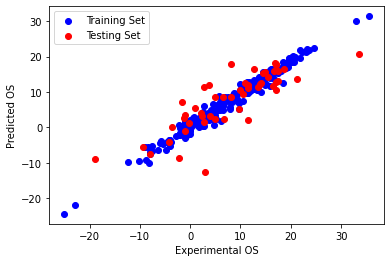

In [6]:
plt.clf()
plt.xlabel('Experimental OS')
plt.ylabel('Predicted OS')
plt.scatter(y_train, y_hat_train, color='blue', label='Training Set')
plt.scatter(y_test, y_hat_test, color='red', label='Testing Set')
plt.legend(loc='upper left')
plt.show()